### AB Testing - Pricing Test 
### Goal
Pricing optimization is, non surprisingly, another area where data science can provide huge value.
The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

### Questions:
1. Should the company sell its software for 39 or 59 dollars?
2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
3. The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.


# Index
* [Load the data](#Load-the-data)
* [Check whether test/control group is randomly splitted?](#Check-whether-test-and-control-group-is-randomly-splitted?)
* [Question 1:](#Question-1:)
    * [1. Visualization](#1.-Visualization)
    * [2. Chi-Square Test](#2.-Chi-Square-Test)

* [Question 2:](#Question-2:)
    * [1. Chi-Square Test](#1.-Chi-Square-Test)
    * [2. Visualization](#2.-Visualization)
    * [3. Decision tree](#3.-Decision-tree)
    * [4. Actionable Insights](#4.-Actionable-Insights)
* [Question 3:](#Question-3:)    
    

In [4]:
import os
import re
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
seed = 999

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz 
from sklearn import tree
from six import StringIO
from IPython.display import Image  
import pydotplus

### Load the data

In [5]:
os.chdir("C://Users/htche/Desktop")

In [6]:
testdf = pd.read_csv("test_results.csv") 
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [7]:
testdf.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [8]:
testdf.shape

(316800, 8)

In [9]:
testdf.describe(include='all')

,user_id,timestamp,source,device,operative_system,test,price,converted
count,316800.000000,316800,316800,316800,316800,316800.000000,316800.000000,316800.000000
unique,NaN,140931,12,2,6,NaN,NaN,NaN
top,NaN,2015-04-12 11:51:16,direct_traffic,mobile,windows,NaN,NaN,NaN
freq,NaN,12,60357,186471,100976,NaN,NaN,NaN
mean,499281.341840,NaN,NaN,NaN,NaN,0.360079,46.205051,0.018333
std,288591.154044,NaN,NaN,NaN,NaN,0.480024,9.601487,0.134154
min,3.000000,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000
25%,249525.750000,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000
50%,499021.500000,NaN,NaN,NaN,NaN,0.000000,39.000000,0.000000
75%,749025.500000,NaN,NaN,NaN,NaN,1.000000,59.000000,0.000000


In [10]:
userdf = pd.read_csv("user_table.csv") 
userdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [11]:
userdf.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [12]:
userdf.shape

(275616, 5)

In [13]:
userdf.describe(include = 'all')

,user_id,city,country,lat,long
count,275616.000000,275616,275616,275616.000000,275616.000000
unique,NaN,923,1,NaN,NaN
top,NaN,New York,USA,NaN,NaN
freq,NaN,25748,275616,NaN,NaN
mean,499245.801521,NaN,NaN,37.111680,-93.981772
std,288533.458944,NaN,NaN,5.209627,18.086486
min,3.000000,NaN,NaN,19.700000,-157.800000
25%,249544.500000,NaN,NaN,33.660000,-112.200000
50%,498861.000000,NaN,NaN,37.740000,-88.930000
75%,748856.500000,NaN,NaN,40.700000,-78.910000


In [14]:
# merge test_results with user_table
df = pd.merge(left=testdf, right=userdf, how='left', on='user_id')
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [15]:
# count unique user_id
df['user_id'].value_counts()

2047      1
338394    1
465846    1
407572    1
753429    1
         ..
291876    1
293925    1
857669    1
814119    1
2049      1
Name: user_id, Length: 316800, dtype: int64

In [16]:
# count unique value
df.nunique()

user_id             316800
timestamp           140931
source                  12
device                   2
operative_system         6
test                     2
price                    2
converted                2
city                   923
country                  1
lat                    713
long                   830
dtype: int64

In [17]:
df['test'].value_counts()

0    202727
1    114073
Name: test, dtype: int64

In [18]:
print(114073/(202727+114073))
print(202727/(202727+114073))

0.36007891414141413
0.6399210858585859


In the experiment description, 66% of the users have seen the old price 39,while a randomsample of 33% users a higher price 59. 
However, in our dataset, 36% of the users have seen new price and 64% of the users have seen new price.

In [19]:
# check price in test & control group
df[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

In [20]:
print((210+155)/(202727+114073))

0.0011521464646464647


Some values in test doesn't match with the price (210 users in control group have seen new price and 155 users in test group have seen old price.). Since these problematic inputs only take account of a small portion of the whole data set (0.0011%), so we decide to remove these problematic inputs.

In [21]:
# only keep the valid data
newdf = df[((df['test']==0) & (df['price']==39)) | ((df['test']==1) & (df['price']==59))]
newdf[['price', 'test', 'user_id']].groupby(['test', 'price']).count()

,,user_id
test,price,
0,39,202517
1,59,113918


In [22]:
# create new column called 'revenue'
newdf['revenue'] = newdf['converted'] * newdf['price']

<ipython-input-22-6ea506390cac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf['revenue'] = newdf['converted'] * newdf['price']


In [23]:
newdf.head(10)

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0
5,169971,2015-04-13 12:07:08,ads-google,mobile,iOS,0,39,0,New York,USA,40.67,-73.94,0
6,600150,2015-03-04 14:45:44,seo_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN,0
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,East Orange,USA,40.77,-74.21,59
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,Dayton,USA,39.78,-84.20,0
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59,0,Richmond,USA,37.53,-77.47,0


In [24]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316435 entries, 0 to 316799
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           316435 non-null  int64  
 1   timestamp         316435 non-null  object 
 2   source            316435 non-null  object 
 3   device            316435 non-null  object 
 4   operative_system  316435 non-null  object 
 5   test              316435 non-null  int64  
 6   price             316435 non-null  int64  
 7   converted         316435 non-null  int64  
 8   city              275294 non-null  object 
 9   country           275294 non-null  object 
 10  lat               275294 non-null  float64
 11  long              275294 non-null  float64
 12  revenue           316435 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 33.8+ MB


In [25]:
#check NA
newdf.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
revenue                 0
dtype: int64

### Check whether test and control group is randomly splitted?

#### 1. Visualization

In [26]:
# a. Source
# Check bar chart
source = newdf.groupby('test')['source'].apply(lambda x: x.value_counts(normalize=True)).unstack()
source

,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072014,0.186873,0.023761,0.168253,0.095083,0.191154,0.064790,0.006562,0.074502,0.029030,0.021509,0.066468
1,0.072394,0.188706,0.024219,0.169253,0.092786,0.189259,0.066337,0.007154,0.070753,0.029539,0.021814,0.067786


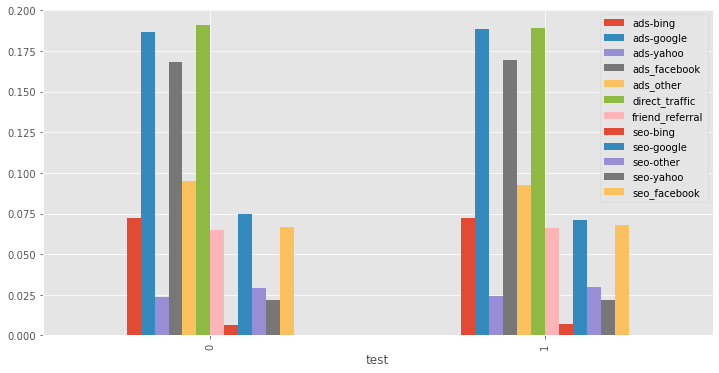

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
source.plot(kind='bar', ax=ax)
plt.show()

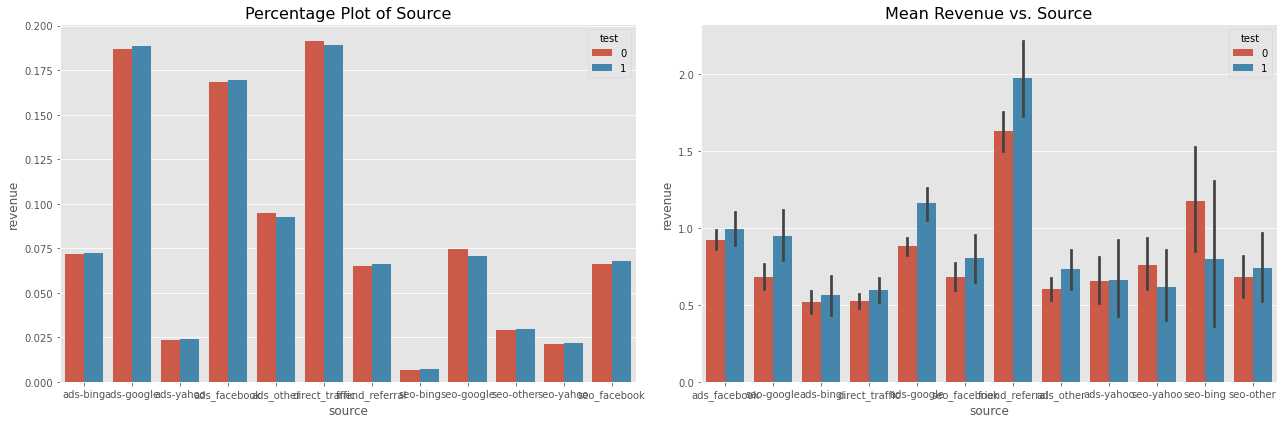

In [28]:
# Visualization of source
count = newdf[['source', 'test', 'revenue']].groupby(['source', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='source', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Source', fontsize=16)

sns.barplot(x='source', y='revenue', hue='test', data=newdf, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Source', fontsize=16)
plt.tight_layout()
plt.show()

In [29]:
#b. Device
# Check bar chart
de = newdf.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()
de

,mobile,web
test,,
0,0.594365,0.405635
1,0.578469,0.421531


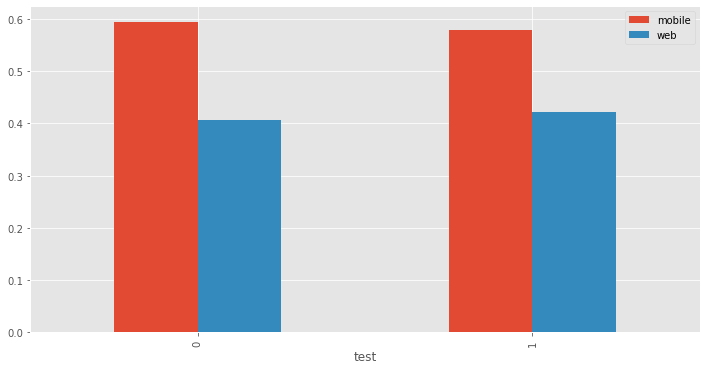

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
de.plot(kind='bar', ax=ax)
plt.show()

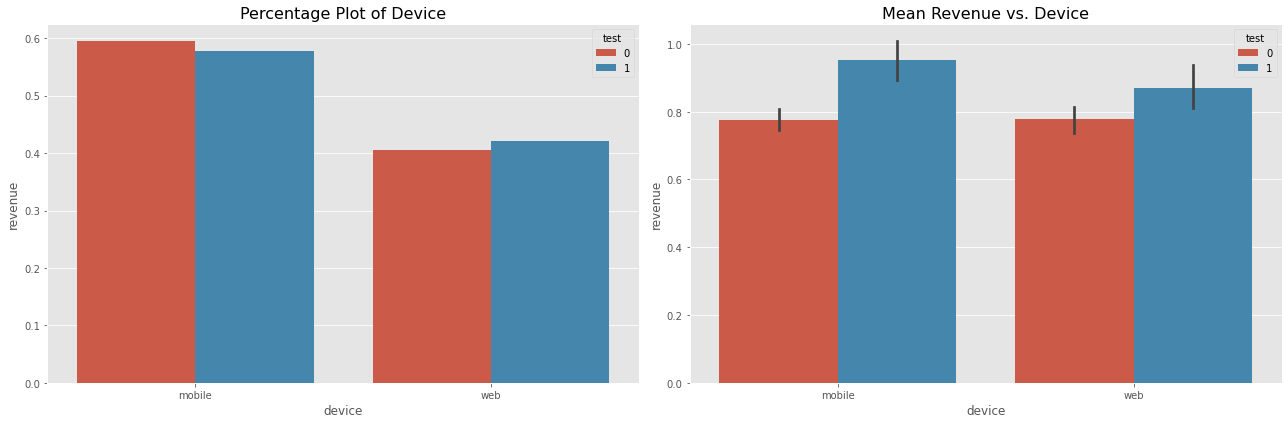

In [31]:
# Visualization of device
count = newdf[['device', 'test', 'revenue']].groupby(['device', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / 113918
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / 202517

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.barplot(x='device', y='revenue', hue='test', data=count, ax=ax[0])
ax[0].set_title('Percentage Plot of Device', fontsize=16)

sns.barplot(x='device', y='revenue', hue='test', data=newdf, ax=ax[1])
ax[1].set_title('Mean Revenue vs. Device', fontsize=16)
plt.tight_layout()
plt.show()

In [32]:
#c. Operative System
ost = newdf.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
ost

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


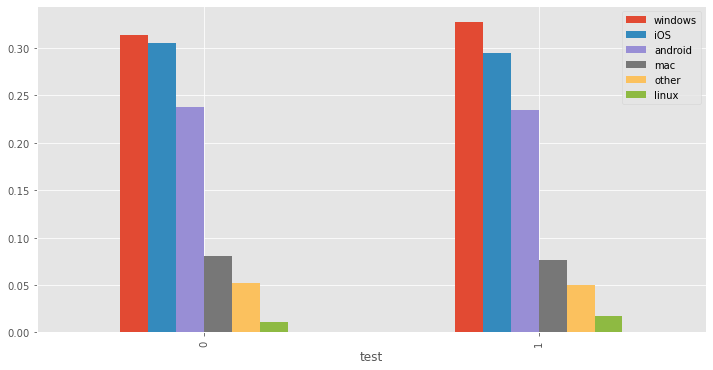

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
ost.plot(kind='bar', ax=ax)
plt.show()

In [34]:
df_OS = newdf[['operative_system','test']]
df_OS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316435 entries, 0 to 316799
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   operative_system  316435 non-null  object
 1   test              316435 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 17.2+ MB


In [35]:
df_OS.head()

,operative_system,test
0,iOS,0
1,android,0
2,android,0
3,iOS,1
4,mac,0


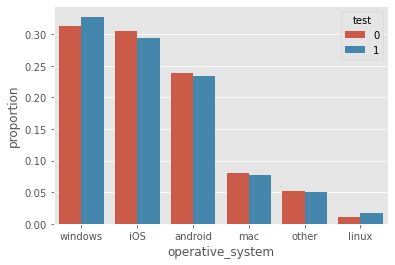

In [36]:
(df_OS['operative_system']
 .groupby(df_OS['test'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='operative_system', y='proportion', hue='test'))

From the above tables and plots, we can find that the operative system distribution of control and test groups are different. So, the test and control group are not randomly splitted in OS.

#### 2. Chi-Square Test
The Chi-square test of independence is a statistical hypothesis test used to determine whether two categorical or nominal variables are likely to be related or not.

In [37]:
newdf2 = newdf.copy()
del newdf2['timestamp']

# to use sklearn to check feature importance, we must convert string values to numbers
src_label_encoder = LabelEncoder()
dev_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

newdf2["source"] = src_label_encoder.fit_transform(newdf.source)
newdf2["device"] = dev_label_encoder.fit_transform(newdf.device)
newdf2["operative_system"] = os_label_encoder.fit_transform(newdf.operative_system)
newdf2.head()

,user_id,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,3,0,1,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,8,0,0,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,0,0,0,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,5,0,1,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,3,1,3,0,39,0,Fishers,USA,39.95,-86.02,0


In [38]:
# run Chi-Square test to see which factor impact the splitting between test/control group
colnames = ["source","device","operative_system"]
ch2values,pvalues = chi2(newdf2.loc[:,colnames],newdf2["test"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
operative_system,83.937937,5.105534e-20
device,44.785346,2.198620e-11
source,0.918060,3.379849e-01


In [39]:
# OS distribution
def calc_ratios(s):
    d = s.value_counts(normalize=True) 
    d['total'] = s.shape[0] 
    return d
os_ratio = newdf.groupby('operative_system')['test'].apply(calc_ratios).unstack()
os_ratio

,0,1,total
operative_system,,,
android,0.643475,0.356525,74870.0
iOS,0.648045,0.351955,95353.0
linux,0.533656,0.466344,4130.0
mac,0.652365,0.347635,25055.0
other,0.647895,0.352105,16177.0
windows,0.629817,0.370183,100850.0


In [40]:
# device
def calc_ratios(s): 
    d = s.value_counts(normalize=True) 
    d['total'] = s.shape[0] 
    return d
device_ratio = newdf.groupby('device')['test'].apply(calc_ratios).unstack()
device_ratio

,0,1,total
device,,,
mobile,0.646218,0.353782,186267.0
web,0.631092,0.368908,130168.0


In the experiment, there should be 66% of the users in the control group, and 34% users in the testgroup. The chi-squared and operative systems results show that the splitting between test and control groups of operative systems aren't random. The chi-squared value of operative systems is 83.93 and it is significant. The result indicates that the distribution of operative systems in control and test grops are different. Moreover, the operative distribution table shows that linux users in control and test groups are 53% and 46%, respectively.

### Question 1:

### Should the company sell its software for 39 𝑜𝑟 59 dollars?

In [41]:
#check the conversion rate &  for A/B test
print(newdf[['test', 'converted']].groupby('test').mean())
print()
print(newdf[['test', 'revenue']].groupby('test').mean())

      converted
test           
0      0.019900
1      0.015555

       revenue
test          
0     0.776083
1     0.917748


In [42]:
# check mean of conversion rate and revenue for A/B test
def group_statistics(newdf):
    return pd.Series({'n_users': newdf.shape[0], 
                    'convert_rate': newdf.converted.mean(), 
                    'mean_revenue': newdf.revenue.mean() 
                    })
newdf.groupby('test').apply(group_statistics)

,n_users,convert_rate,mean_revenue
test,,,
0,202517.0,0.019900,0.776083
1,113918.0,0.015555,0.917748


We find that the control group has higher conversion rate and the test group generates higheraverage revenue. Next, we will perform a t-test to test whether the test group's average revenue ishigher than control group's average revenue. The hypothesis is as follows.
H0: test group'saverage revenue is equal to or less than control group's average revenue
H1: test group's average revenue is higher than control group's average revenue

In [43]:
# run t-test
# ttest_ind is a two tailed
# since our HA is test_mean > ctrl_mean, so we need to divide by 2

controlrev = newdf[newdf['test'] == 0]['revenue'].values
testrev = newdf[newdf['test'] == 1]['revenue'].values
ttest = ss.ttest_ind(testrev, controlrev, equal_var=False)
print(ss.ttest_ind(testrev, controlrev, axis=0, equal_var=False))
print(ttest.pvalue/2)

Ttest_indResult(statistic=5.715224666463108, pvalue=1.0972577312420781e-08)
5.486288656210391e-09


Since the p-value is < 0.05, we reject the null. The results indicate that test group's average revenue is higher than control group's average revenue. However, due to the distribution of operative systems in control and test grops are different, we can't not conclude that the company should sell its software for $59.
We suggest that it is critical to find out the reason why linux users have different distribution ratio than other operative systems. After we fixed the linux users distribution issue, we could re-run the experiment and then run the t-test to see if test group's average revenue is higher than control group's average revenue.

### Question 2:

### The VP of Product is interested in having a holistic view into userbehavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

#### 1. Chi-Square Test

In [44]:
# run Chi-Square test to see which factor impact the converted
colnames = ["source", "device", "operative_system", 'price']
ch2values,pvalues = chi2(newdf2.loc[:,colnames], newdf2["converted"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
price,152.509801,4.902372e-35
operative_system,7.378510,6.600782e-03
source,2.451427,1.174181e-01
device,0.706940,4.004615e-01


Take significance level at 0.05. The Chi-Square test results show that the price and operative systems are significant, so we conclude that the price and operative systems impacted the conversion rate. 

In [45]:
# Price
price_convert = newdf.groupby("price")['converted'].apply(lambda s:s.value_counts(normalize = True)).unstack()
price_convert

,0,1
price,,
39,0.980100,0.019900
59,0.984445,0.015555


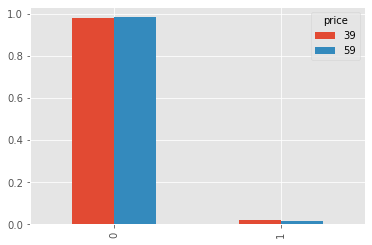

In [46]:
price_convert.transpose().plot(kind='bar')

In [47]:
price_convert1 = newdf.groupby("converted")['price'].apply(lambda s:s.value_counts(normalize = True)).unstack()
price_convert1

,39,59
converted,,
0,0.638976,0.361024
1,0.694588,0.305412


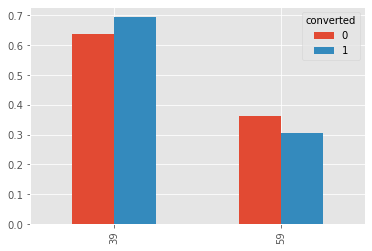

In [48]:
price_convert1.transpose().plot(kind='bar')

test group users have lower conversion rate than control group users

In [49]:
# Operative_system
os_convert = newdf.groupby("operative_system")['converted'].apply(lambda s:s.value_counts(normalize = True)).unstack()
os_convert

,0,1
operative_system,,
android,0.985081,0.014919
iOS,0.977672,0.022328
linux,0.991768,0.008232
mac,0.976013,0.023987
other,0.987019,0.012981
windows,0.983034,0.016966


In [50]:
# Operative_system 1
os_convert1 = newdf.groupby("converted")['operative_system'].apply(lambda s:s.value_counts(normalize = True)).unstack()
os_convert1

,android,iOS,linux,mac,other,windows
converted,,,,,,
0,0.237428,0.300110,0.013186,0.078723,0.051401,0.319152
1,0.192520,0.366942,0.005860,0.103585,0.036194,0.294898


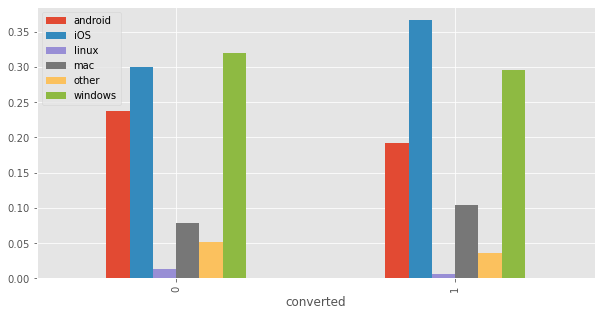

In [51]:
os_convert1.plot(kind='bar',figsize=(10,5))

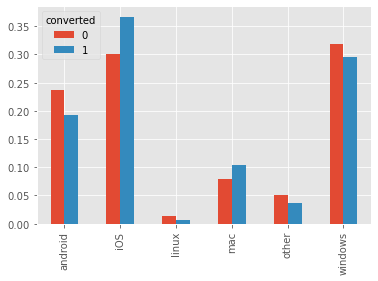

In [52]:
os_convert1.transpose().plot(kind='bar')

In test group, the ios and mac users have higher conversion rate than other os users. 

#### 2. Visualization

In [54]:
#1. Source
source_convert = newdf.groupby("source")['converted'].apply(lambda s:s.value_counts(normalize = True)).unstack()
source_convert

,0,1
source,,
ads-bing,0.987999,0.012001
ads-google,0.978498,0.021502
ads-yahoo,0.985207,0.014793
ads_facebook,0.978802,0.021198
ads_other,0.985650,0.014350
direct_traffic,0.987706,0.012294
friend_referral,0.961312,0.038688
seo-bing,0.976213,0.023787
seo-google,0.983022,0.016978


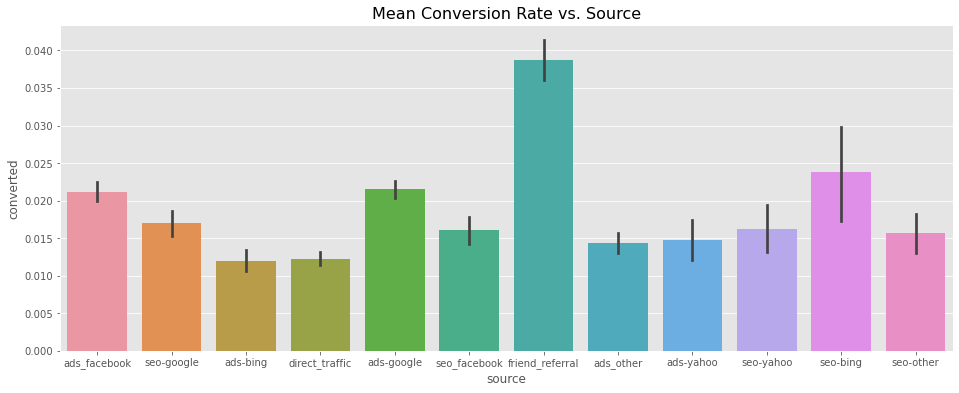

In [55]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=newdf, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

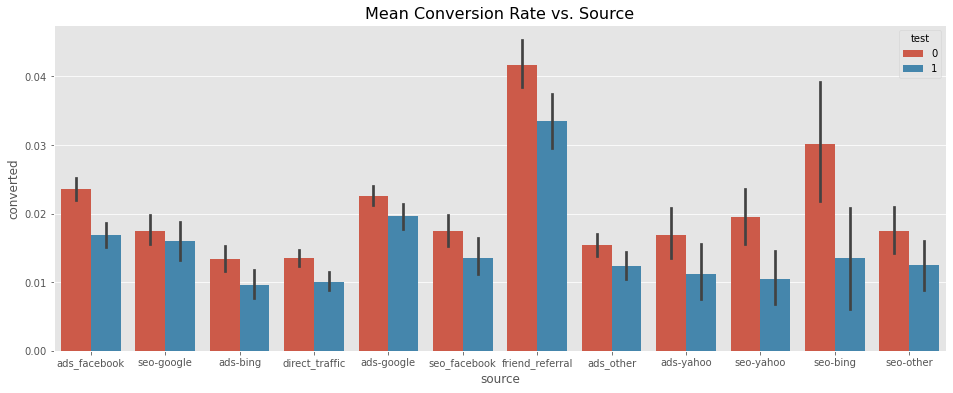

In [56]:
# Visualization of source
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', hue='test', data=newdf, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

Friend referral has the highest conversion rate 3.8% in test group users. Friend referral has the highest conversion rate in control group as well.

In [57]:
#2. Device
device_convert = newdf.groupby("device")['converted'].apply(lambda s:s.value_counts(normalize = True)).unstack()
device_convert

,0,1
device,,
mobile,0.981446,0.018554
web,0.981977,0.018023


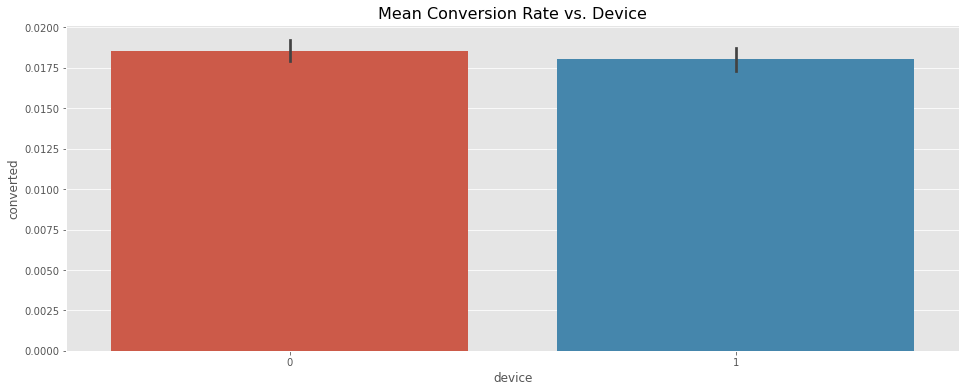

In [58]:
# Visualization of device
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='device', y='converted', data=newdf2, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

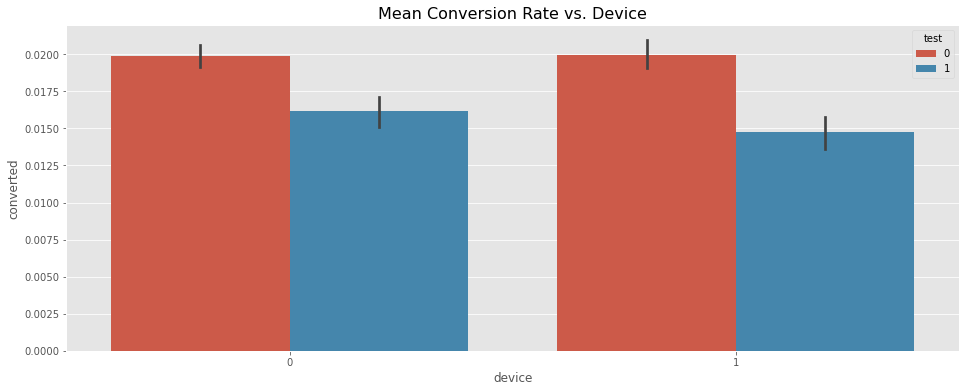

In [59]:
# Visualization of device
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='device', y='converted', hue='test', data=newdf2, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

Device-mobile & web have similar conversion rate 1.8%

In [60]:
#3. Operative systems
o_convert = newdf.groupby("operative_system")['converted'].apply(lambda s:s.value_counts(normalize = True)).unstack()
o_convert

,0,1
operative_system,,
android,0.985081,0.014919
iOS,0.977672,0.022328
linux,0.991768,0.008232
mac,0.976013,0.023987
other,0.987019,0.012981
windows,0.983034,0.016966


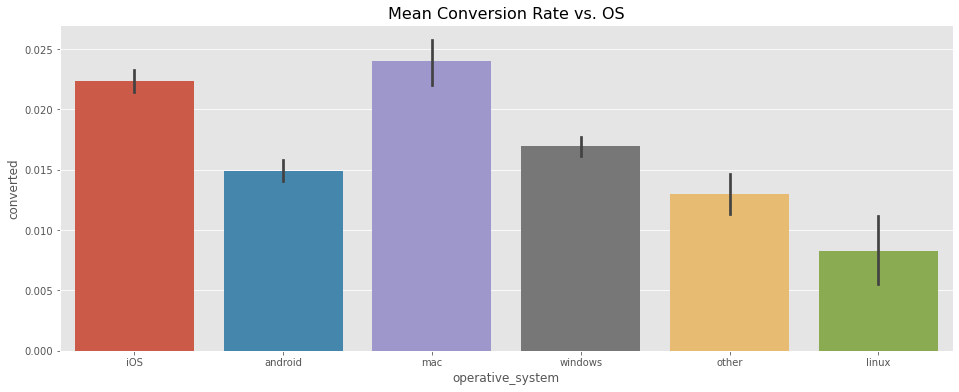

In [61]:
# Visualization of os
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='operative_system', y='converted', data=newdf, ax=ax)
ax.set_title('Mean Conversion Rate vs. OS', fontsize=16)
plt.show()

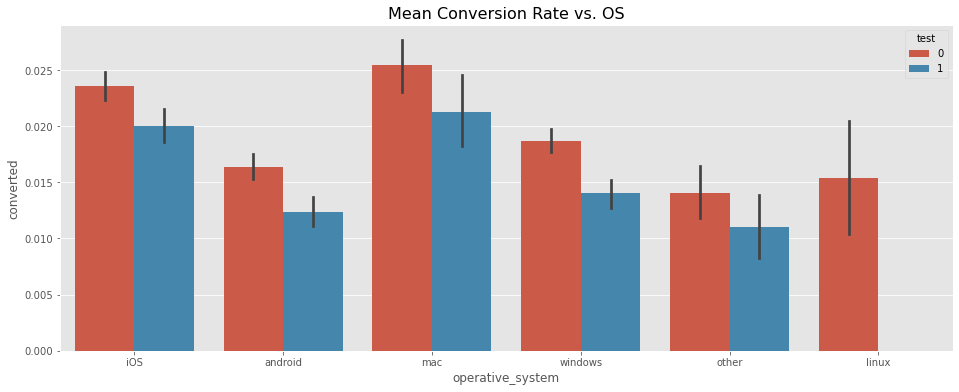

In [62]:
# Visualization of os
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='operative_system', y='converted',hue='test', data=newdf, ax=ax)
ax.set_title('Mean Conversion Rate vs. OS', fontsize=16)
plt.show()

From the above visualization results, we find that friend referral has the highest conversion rate 3.8% in test group users. Friend referral has the highest conversion rate in control group as well.
Next, device does not impact conversion rate. Mobile & web have similar conversion rate around 1.8%
Third, mac and iOS users have the highest conversion rate. The conversion rate of mac and iOS is 2.2% and 2.3%, respectively. Linux users has the lowest conversion rate. The conversion rate of linux is 0.8%.

#### 3. Decision tree

In [63]:
### 3. Decision tree - build a Decision tree to get feature importance
newdf3 = newdf.copy()
newdf3.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


In [64]:
newdf3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316435 entries, 0 to 316799
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           316435 non-null  int64  
 1   timestamp         316435 non-null  object 
 2   source            316435 non-null  object 
 3   device            316435 non-null  object 
 4   operative_system  316435 non-null  object 
 5   test              316435 non-null  int64  
 6   price             316435 non-null  int64  
 7   converted         316435 non-null  int64  
 8   city              275294 non-null  object 
 9   country           275294 non-null  object 
 10  lat               275294 non-null  float64
 11  long              275294 non-null  float64
 12  revenue           316435 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 33.8+ MB


In [65]:
del newdf3['user_id']
del newdf3['timestamp']
del newdf3['test']
del newdf3['city']
del newdf3['country']
del newdf3['lat']
del newdf3['long']
del newdf3['revenue']

In [66]:
# One-Hot-Encoding on categorical features
newdf3 = pd.get_dummies(newdf3)
newdf3.head()

,price,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,...,source_seo-yahoo,source_seo_facebook,device_mobile,device_web,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows
0,39,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,39,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,39,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,59,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
4,39,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [67]:
newdf3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316435 entries, 0 to 316799
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   price                     316435 non-null  int64
 1   converted                 316435 non-null  int64
 2   source_ads-bing           316435 non-null  uint8
 3   source_ads-google         316435 non-null  uint8
 4   source_ads-yahoo          316435 non-null  uint8
 5   source_ads_facebook       316435 non-null  uint8
 6   source_ads_other          316435 non-null  uint8
 7   source_direct_traffic     316435 non-null  uint8
 8   source_friend_referral    316435 non-null  uint8
 9   source_seo-bing           316435 non-null  uint8
 10  source_seo-google         316435 non-null  uint8
 11  source_seo-other          316435 non-null  uint8
 12  source_seo-yahoo          316435 non-null  uint8
 13  source_seo_facebook       316435 non-null  uint8
 14  device_mobile       

In [68]:
Xtrain = newdf3.loc[:,newdf3.columns != 'converted']
ytrain = newdf3.loc[:,'converted']

In [69]:
Xtrain.head()

,price,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,...,source_seo-yahoo,source_seo_facebook,device_mobile,device_web,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows
0,39,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,39,0,0,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,39,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,59,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,39,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [70]:
ytrain.head()

0    0
1    0
2    0
3    0
4    0
Name: converted, dtype: int64

In [71]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(Xtrain,ytrain)
dot_data = tree.export_graphviz(dt, feature_names=Xtrain.columns,
                         proportion=True, leaves_parallel=True)
graph = graphviz.Source(dot_data)
graph.render(filename='g1.dot')

'g1.dot.pdf'

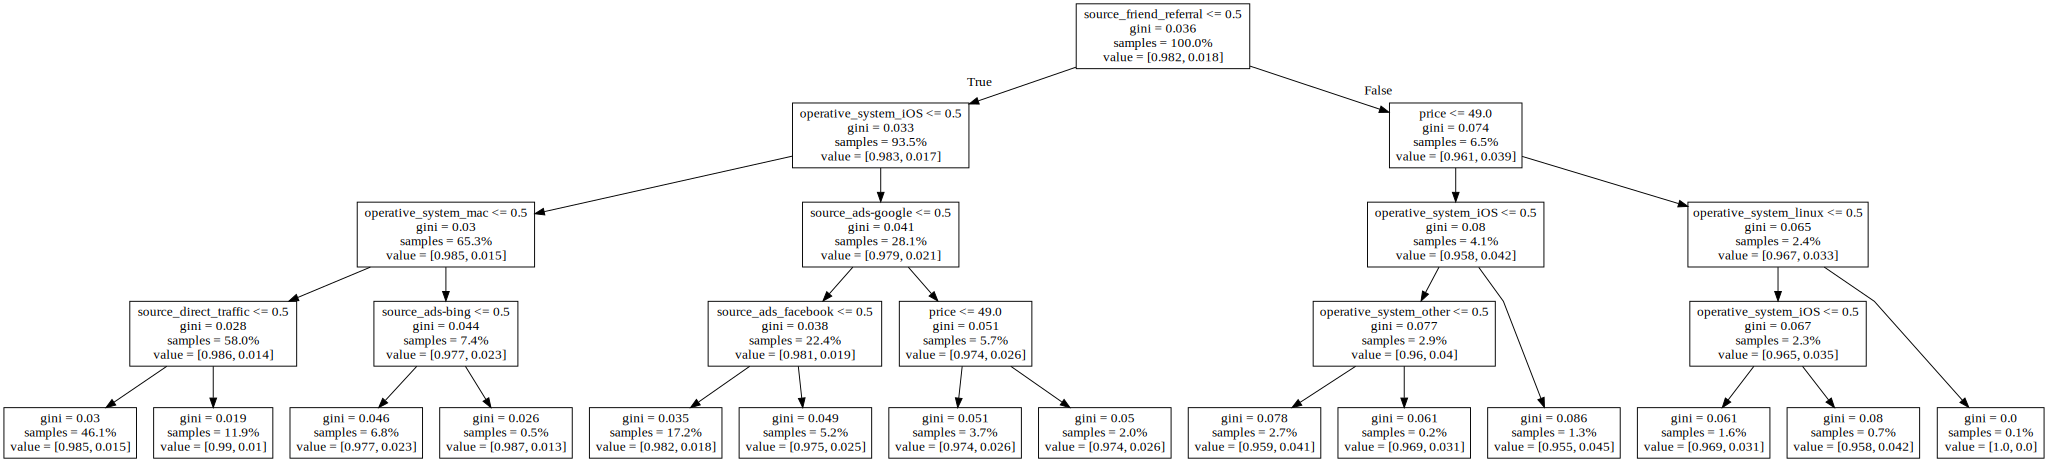

In [72]:
graph

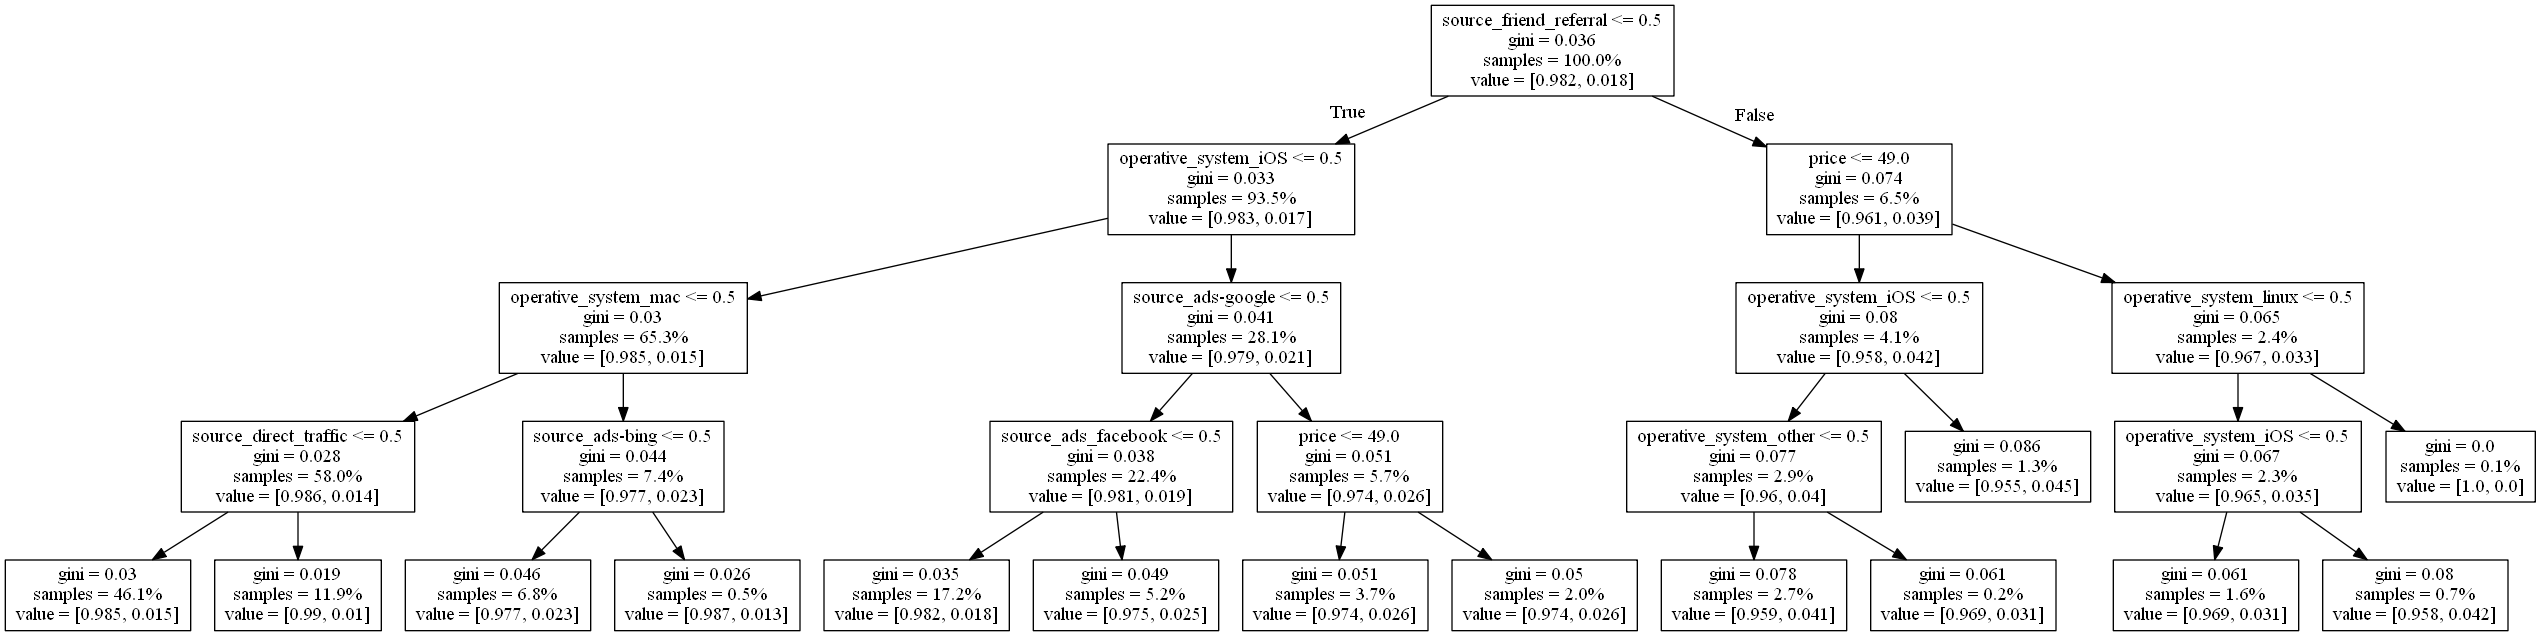

In [73]:
# Visualize the Tree on notebook
dot_data = export_graphviz(dt, feature_names=Xtrain.columns,
                         proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [74]:
pd.Series(dt.feature_importances_,index = Xtrain.columns).sort_values(ascending=False)

source_friend_referral      0.580116
operative_system_iOS        0.136718
operative_system_mac        0.093261
source_direct_traffic       0.059365
source_ads_facebook         0.041252
source_ads-google           0.038684
price                       0.020464
operative_system_linux      0.016906
source_ads-bing             0.010423
operative_system_other      0.002811
source_ads-yahoo            0.000000
source_ads_other            0.000000
operative_system_windows    0.000000
source_seo-bing             0.000000
source_seo-google           0.000000
source_seo-yahoo            0.000000
source_seo_facebook         0.000000
device_mobile               0.000000
device_web                  0.000000
operative_system_android    0.000000
source_seo-other            0.000000
dtype: float64

#### 4. Actionable Insights
Friend_referral, Apple user (MAC or iOS), and low price are three main positive factors that affect the conversion rate. If we want to increase the price, which impacts negatively on conversion rate, we can consider to 1) launch special marketing program targeted to Apple users (MAC or iOS users) and 2) run some referral program to encourage users to invite his/her friend to use our software. In addition, Linux users seem don't like our software as much as users on other OS. Development team should find out the reason. For example, is there any incompatibility issue on Linux?

### Question 3:

### The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

#### Method: Using P-value comparison by day
We can plot pvalue day by day. That is, pvalue after 1 day, after 2 days, etc. At some point, it will converge and not change anymore. That's when we don't need any new data. This approach is more empirical.
After 10th day, the p-value is >0.05 and after that high p-value indicates not too much difference in conversion

In [90]:
data_test =newdfz[newdfz['test']==1]
data_control =newdfz[newdfz['test']==0]
print(len(data_test), len(data_control))# split between test & control

113918 202517


In [91]:
date_list = newdfz['date'].unique()
output = []
converted_test = []
converted_control = []
n_samples_test = []
n_samples_control = []
test_statistics = []

for date in date_list:
    data_test_bydate =data_test[data_test['date']==date]
    data_control_bydate =data_control[data_control['date']==date]
    output.append(stats.ttest_ind(data_test_bydate['converted'], data_control_bydate['converted']).pvalue)
    converted_test.append(data_test_bydate['converted'].mean())
    converted_control.append(data_control_bydate['converted'].mean())
    n_samples_test.append(len(data_test_bydate))
    n_samples_control.append(len(data_control_bydate))
    test_statistics.append(stats.ttest_ind(data_test_bydate['converted'], data_control_bydate['converted']).statistic)
    
final_df = data=pd.DataFrame({'Date':date_list, 'P_Value':output, 'test_statistic':test_statistics,'converted_test':converted_test,'converted_control':converted_control
                             ,'n_samples_test':n_samples_test,'n_samples_control':n_samples_control})

output = final_df.sort_values(by='P_Value', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last').reset_index(drop=True).head(60)
output

,Date,P_Value,test_statistic,converted_test,converted_control,n_samples_test,n_samples_control
0,2015-05-03,0.000942,-3.309626,0.008130,0.021402,1599,2710
1,2015-04-03,0.006180,-2.738934,0.013548,0.023251,2362,4559
2,2015-04-29,0.009405,-2.600423,0.008446,0.027810,592,863
3,2015-05-17,0.009964,-2.578250,0.014360,0.026461,1532,2721
4,2015-03-16,0.012581,-2.498674,0.010309,0.031974,485,907
5,2015-05-25,0.013560,-2.471872,0.007648,0.026498,523,868
6,2015-04-09,0.022249,-2.287292,0.009407,0.020591,1063,1894
7,2015-03-17,0.023340,-2.270101,0.005917,0.021548,507,1021
8,2015-04-17,0.023577,-2.264445,0.015420,0.023302,2594,4549
9,2015-04-26,0.028096,-2.196709,0.013939,0.023613,1650,2541


After the 10th day, the p-value is >0.05 and after that high p-value indicates not too much difference in conversion. Hence, I would recommend to run the experiment at least 2 full weeks. Also, we can capture the weekly patterns if we run the experiments for at least 2 weeks. <br>